
# 지하철, 버스 역세권, 버세권 파생변수 추가

- 역세권
1차 역세권: 250 이내
2차 역세권: 250~500 이내

- 버세권
1차버세권: 250이내

In [1]:
# sys.path를 수정하여 모듈 경로를 설정
import sys
import os
import pandas as pd

# 프로젝트 루트 경로 추가
project_root = os.path.abspath("..")
sys.path.append(project_root)

import module

In [2]:
# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns

# utils
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')

# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

import eli5
from eli5.sklearn import PermutationImportance

In [3]:
df = module.file_load.load_current_version()

In [4]:
subway_df = module.file_load.load_지하철()
bus_df = module.file_load.load_버스()

In [5]:
print(subway_df.head(1))
print(bus_df.head(1))

   역사_ID 역사명   호선         위도          경도
0   9996  미사  5호선  37.560927  127.193877
       노드 ID  정류소번호     정류소명         X좌표        Y좌표 정류소 타입
0  100000001   1001  종로2가사거리  126.987752  37.569808   중앙차로


In [6]:
module.file_load.current_version

'v5'

In [7]:
concat_select = module.preprocess.결측치_제거_100만개_이상(df)

In [8]:
module.preprocess.범주형_타입변환(df)

In [9]:
subway_df = subway_df.rename(columns={'위도': 'y', '경도': 'x'})
bus_df = bus_df.rename(columns={'Y좌표': 'y', 'X좌표': 'x'})

In [10]:
concat_select = module.preprocess.calculate_nearest_subway_distance(concat_select, subway_df, 'nearest_subway_distance')


In [11]:
concat_select['nearest_subway_distance'] = concat_select['nearest_subway_distance'].apply(lambda x: x * 100000)

In [12]:
concat_select[3500:3501]

,시군구,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,...,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일,target,금리_단기1년전차이,is_test,nearest_subway_distance
3500,서울특별시 강남구 개포동,138,138.0,0.0,디에이치아너힐즈,84.3558,202010,31,29,2019,...,NaN,NaN,NaN,127.06796,37.48444,NaN,289000.0,-0.75,0,5.017592e+07


In [13]:
module.preprocess.역세권_add(concat_select)

In [14]:
module.preprocess.시_군_구_add(concat_select)

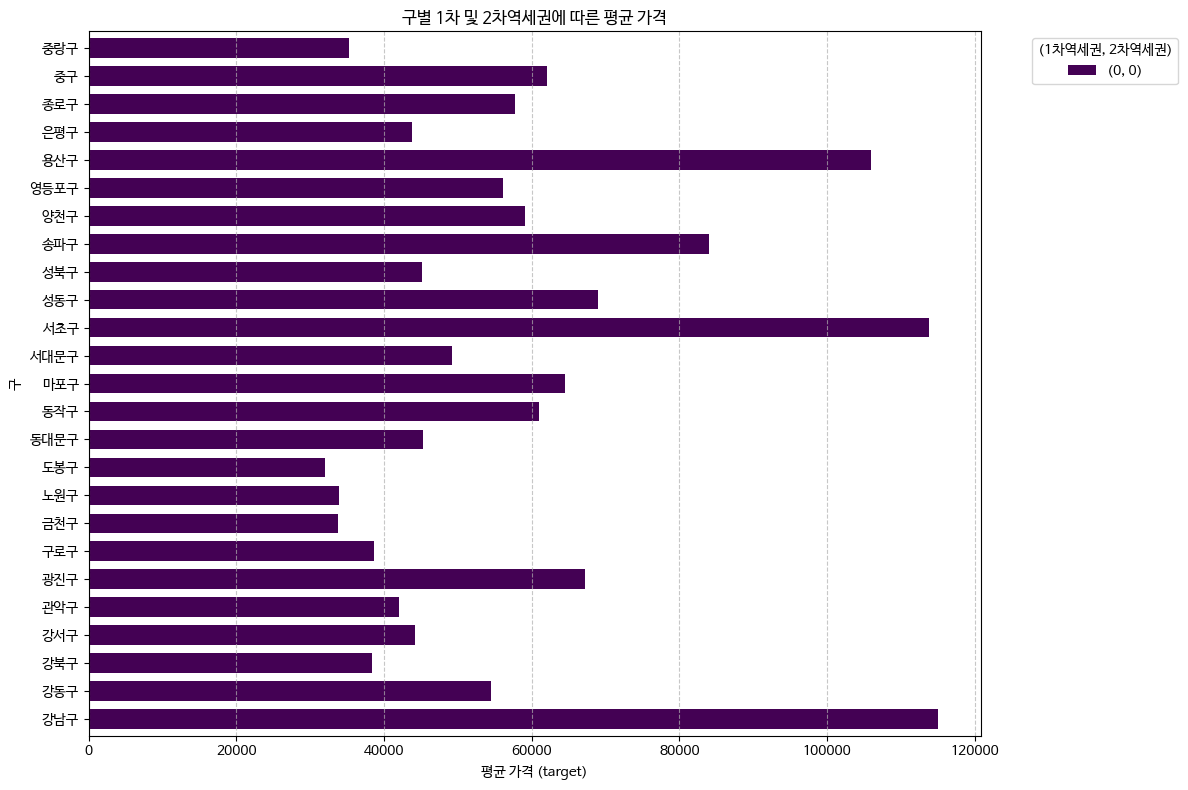

In [15]:

# '구'별로 1차역세권과 2차역세권 평균 계산
avg_prices = concat_select.groupby(['구', '1차역세권', '2차역세권'])['target'].mean().reset_index()

# 데이터 재구성: '구'를 인덱스로 피벗 테이블 만들기
data_pivot = avg_prices.pivot(index='구', columns=['1차역세권', '2차역세권'], values='target')

# 그래프 그리기
def plot_horizontal_bar(data, title, x_label, y_label):
    fig, ax = plt.subplots(figsize=(12, 8))
    data.plot(
        kind='barh',
        ax=ax,
        colormap='viridis',
        width=0.7
    )
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend(
        title='(1차역세권, 2차역세권)',
        bbox_to_anchor=(1.05, 1),
        loc='upper left'
    )
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

plot_horizontal_bar(
    data_pivot,
    title='구별 1차 및 2차역세권에 따른 평균 가격',
    x_label='평균 가격 (target)',
    y_label='구'
)

In [16]:
bus_df.head(1)

,노드 ID,정류소번호,정류소명,x,y,정류소 타입
0,100000001,1001,종로2가사거리,126.987752,37.569808,중앙차로


In [17]:
concat_select = module.preprocess.calculate_nearest_bus_distance(concat_select, bus_df, 'nearest_bus_distance')

In [18]:
module.preprocess.버세권_add(concat_select)

In [19]:
concat_select.head(1)

,시군구,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,...,금리_단기1년전차이,is_test,nearest_subway_distance,1차역세권,2차역세권,시,구,동,nearest_bus_distance,1차버스정류장
0,서울특별시 강남구 개포동,1164-12,1164.0,12.0,새롬,71.72,201709,23,7,2000,...,0.0,0,1.487254e+08,0,0,서울특별시,강남구,개포동,103.447468,1


In [22]:
# nearest_subway_distance
# nearest_subway_distance
concat_select.drop(['nearest_subway_distance', 'nearest_bus_distance'], axis=1, inplace=True)

In [24]:
concat_select.drop(['시', '구','동'], axis=1, inplace=True)

In [25]:
concat_select.head(1)

,시군구,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,...,관리비 업로드,좌표X,좌표Y,단지신청일,target,금리_단기1년전차이,is_test,1차역세권,2차역세권,1차버스정류장
0,서울특별시 강남구 개포동,1164-12,1164.0,12.0,새롬,71.72,201709,23,7,2000,...,NaN,127.052952,37.473188,NaN,64500.0,0.0,0,0,0,1


In [26]:
concat_select['is_test'].value_counts()

0    1116990
1       9272
Name: is_test, dtype: int64

In [27]:
# module.save.save_version(concat_select, 'v6')

v6.csv 파일이 저장되었습니다.
